In [4]:
import numpy as np
import matplotlib.pyplot as plt

We have already done the FTT for 1D and 2D, and checked the analytical solution for a perfect gaussian wave in vacuum. Now, we try to add effects of the atmosphere:

$$\frac{\partial \varepsilon}{\partial z}=-\frac{i}{2k_0}  \Delta_T\varepsilon - \frac{i k_0\delta n(z, y, x)}{2}\varepsilon,  \qquad(Eq. 1)
$$

We begin with the normal spectral class, and will change the advance step with the split step technique. I will work with 1D first again, see the results, then go to 2D

In [45]:
#trying changing the spatial domain

class Spectral:
    def __init__(self, L, number_of_points, k_0):
        self.L = L
        self.number_of_points = number_of_points
        self.k_0 = k_0
        
        
        self.x_grid = np.linspace(-10*L, 10*L, number_of_points, endpoint=False)
        self.k_grid = 2 * np.pi * np.fft.fftfreq(number_of_points, d=20*L/number_of_points)
        
        
        self.D = -1j / (2 * k_0)
        self.epsilon = None
        
    def initialize(self, function):
        if len(function) != self.number_of_points:
            raise ValueError("Function length doesn't match grid size.")
        self.epsilon = function
        
    def step(self, dz):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * self.k_grid**2 * dz)
                
        self.epsilon = np.fft.ifft(epsilon_hat)
        
        return self.epsilon

In [46]:
def advance(spectral, Z, N, n):
    dz = Z / N
    epsilon_evolution = []
    for i in range(N):
        chi = 1j * (n[i]**2-1)*spectral.k_0/2
        a = spectral.step(dz)
        b = a*np.exp(-chi*dz)
        epsilon_evolution.append(b)
        spectral.initialize(b)
    return np.array(epsilon_evolution)

In [47]:
def analytical_solution(Z, D, amplitude, sigma, x_val): #without the atmosphere
    return (amplitude/np.sqrt(1+(4*D*Z/sigma**2))*np.exp(-x_val**2/(sigma**2+4*D*Z)))

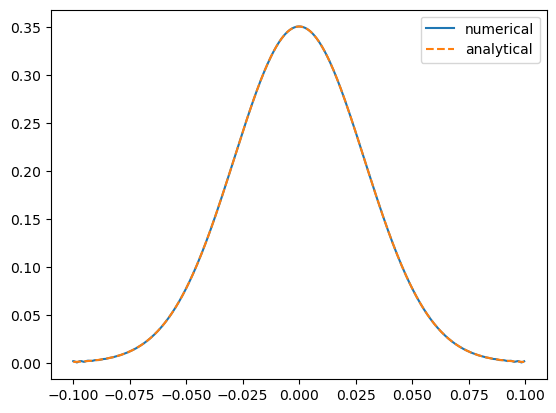

In [48]:
L = 0.01 #Which is the width of the opening of the beam
number_of_points = 2**9 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/635 *10**9 #red light
Z = 1000 #distance of 1km
N = 10**4 #numerically calculate over these many points 
n = 1+ np.linspace(0.5,0, N)

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N, n)

#plt.plot(spectral.x_grid, epsilon_evolution[0], label='initial')
plt.plot(spectral.x_grid, np.abs(epsilon_evolution[-1]), label='numerical')
plt.plot(spectral.x_grid, np.abs(analytical_solution(Z, spectral.D, 1, L/2, spectral.x_grid)),'--', label='analytical')
plt.legend()

In [49]:
# trying by changing the frequency domain
class Spectral:
    def __init__(self, L, number_of_points, k_0):
        self.L = L
        self.number_of_points = number_of_points
        self.k_0 = k_0
        
        
        self.x_grid = np.linspace(-10*L, 10*L, number_of_points, endpoint=False)
        self.k_grid = 2 * np.pi * np.fft.fftfreq(number_of_points, d=20*L/number_of_points)
        
        
        self.D = -1j / (2 * k_0)
        self.epsilon = None
        
    def initialize(self, function):
        if len(function) != self.number_of_points:
            raise ValueError("Function length doesn't match grid size.")
        self.epsilon = function
        
    def step(self, dz, n):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * self.k_grid**2 * dz)
        
        epsilon_hat *= np.exp(-1j * (n**2-1)* self.k_0/2 * dz)
                
        self.epsilon = np.fft.ifft(epsilon_hat)
        
        return self.epsilon
    
def advance(spectral, Z, N, n):
    dz = Z / N
    epsilon_evolution = []
    for i in range(N):
        a = spectral.step(dz, n[i])
        epsilon_evolution.append(a)
    return np.array(epsilon_evolution)

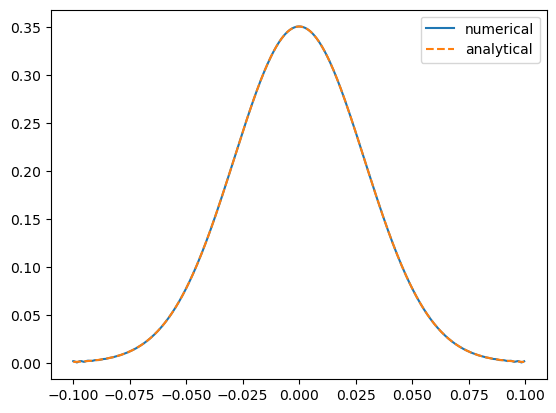

In [50]:
L = 0.01 #Which is the width of the opening of the beam
number_of_points = 2**9 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/635 *10**9 #red light
Z = 1000 #distance of 1km
N = 10**4 #numerically calculate over these many points 
n = 1+ np.linspace(0.5,0, N)

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N, n)

#plt.plot(spectral.x_grid, epsilon_evolution[0], label='initial')
plt.plot(spectral.x_grid, np.abs(epsilon_evolution[-1]), label='numerical')
plt.plot(spectral.x_grid, np.abs(analytical_solution(Z, spectral.D, 1, L/2, spectral.x_grid)),'--', label='analytical')
plt.legend()